In [ ]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models.detection import retinanet_resnet50_fpn


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Constants
EPOCHS = 30
data_dir = "/content/drive/MyDrive/chest_xray/chest_xray"
TEST = 'test'
TRAIN = 'train'
VAL = 'val'


In [ ]:
# Define a function for data transformations
def data_transforms(phase):
    # Apply transformations
    transform = transforms.Compose([
        transforms.Resize(256),  # Resize the image to 256x256 pixels
        transforms.CenterCrop(224),  # Crop the center of the image to 224x224 pixels
        transforms.ToTensor(),  # Convert the image to a PyTorch Tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  # Normalize the Tensor
    ])
    return transform


In [ ]:
# Check if CUDA is available and set the device accordingly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  # Print the device being used


cuda:0


In [ ]:
# Load datasets and apply transformations
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms(x)) for x in [TRAIN, VAL, TEST]}


In [ ]:
# Create a dictionary of dataloaders for each phase
dataloaders = {
    TRAIN: torch.utils.data.DataLoader(image_datasets[TRAIN], batch_size=4, shuffle=True),
    VAL: torch.utils.data.DataLoader(image_datasets[VAL], batch_size=1, shuffle=True),
    TEST: torch.utils.data.DataLoader(image_datasets[TEST], batch_size=1, shuffle=True)
}


In [ ]:
# Get the dataset sizes
dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL]}

# Get the class names from the training dataset
class_names = image_datasets[TRAIN].classes


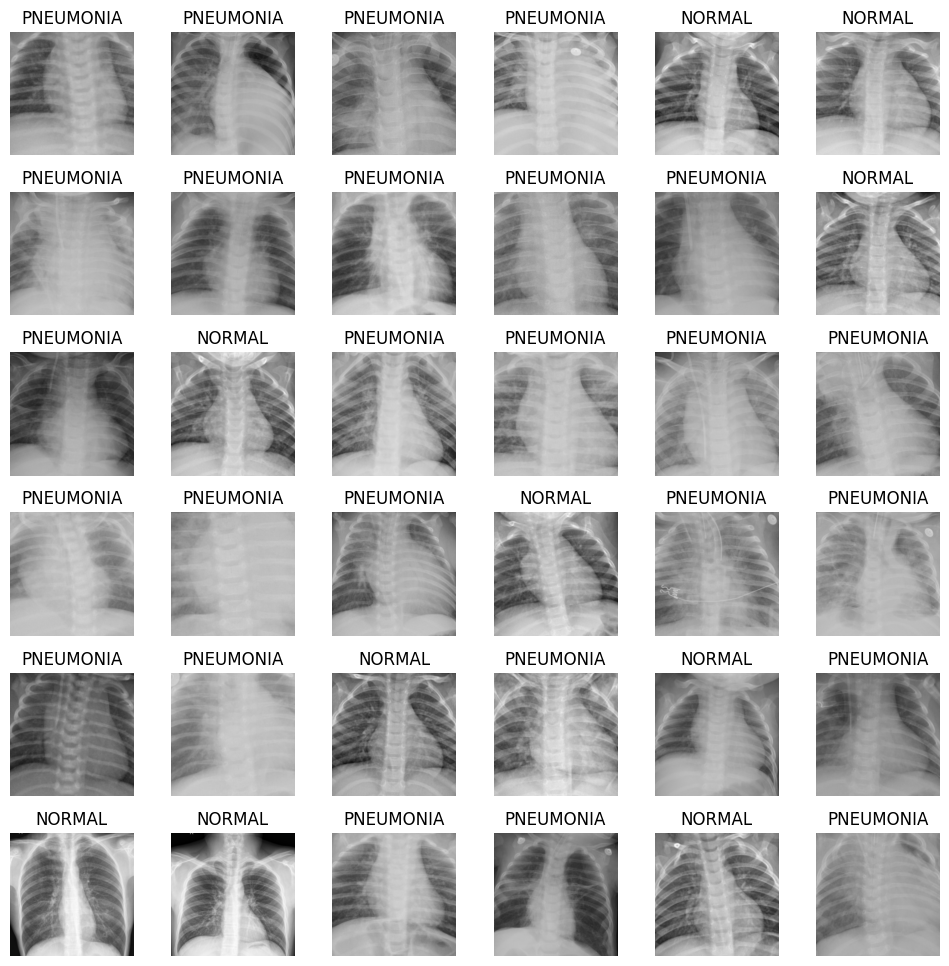

In [ ]:
fig, axes = plt.subplots(6, 6, figsize=(12, 12))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i in range(6):
    for j in range(6):
        inputs, classes = next(iter(dataloaders[TRAIN]))
        input_img = inputs[0]
        class_label = classes[0]
        inp = input_img.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
        axes[i, j].imshow(inp)
        axes[i, j].set_title(class_names[class_label.item()])
        axes[i, j].axis('off')

plt.show()

In [ ]:
import torchvision.models as models
# Load the pre-trained DenseNet-121 model (CheXNet is based on this)
model_pre = models.densenet121(pretrained=True)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 115MB/s] 


In [ ]:

# Modify the classification head for 2 classes (binary classification)
num_classes = 2  # Binary classification
num_ftrs = model_pre.classifier.in_features
model_pre.classifier = nn.Linear(num_ftrs, num_classes)

# Move the model to the device (GPU or CPU)
model_pre = model_pre.to(device)


In [ ]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_pre.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)

# Learning rate scheduler
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


In [ ]:
# Training function
def train_model(model, criterion, optimizer, scheduler, num_epochs=EPOCHS):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("="*10)

        for phase in [TRAIN, VAL]:
            if phase == TRAIN:
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluation mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over the data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == TRAIN):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass + optimize only if in training phase
                    if phase == TRAIN:
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model if new best accuracy is achieved
            if phase == VAL and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Best validation accuracy: {best_acc:.4f}')
    model.load_state_dict(best_model_wts)
    return model



In [ ]:
# Train the RetinaNet model
model_pre = train_model(model_pre, criterion, optimizer, exp_lr_scheduler, num_epochs=10)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


train Loss: 0.1962 Acc: 0.9266
val Loss: 1.4158 Acc: 0.5625
Epoch 2/10
train Loss: 0.1094 Acc: 0.9674
val Loss: 0.1071 Acc: 0.9375
Epoch 3/10
train Loss: 0.0801 Acc: 0.9758
val Loss: 0.1336 Acc: 1.0000
Epoch 4/10
train Loss: 0.0712 Acc: 0.9768
val Loss: 0.5809 Acc: 0.7500
Epoch 5/10
train Loss: 0.0606 Acc: 0.9837
val Loss: 0.4121 Acc: 0.9375
Epoch 6/10
train Loss: 0.0670 Acc: 0.9787
val Loss: 0.1529 Acc: 1.0000
Epoch 7/10
train Loss: 0.0644 Acc: 0.9822
val Loss: 0.1679 Acc: 0.9375
Epoch 8/10
train Loss: 0.0745 Acc: 0.9747
val Loss: 0.2710 Acc: 0.8750
Epoch 9/10
train Loss: 0.0635 Acc: 0.9789
val Loss: 0.8153 Acc: 0.6250
Epoch 10/10
train Loss: 0.0421 Acc: 0.9906
val Loss: 0.1822 Acc: 0.8750
Best validation accuracy: 1.0000


In [ ]:
# Test function
def test_model():
    running_correct = 0.0
    running_total = 0.0
    true_labels = []
    pred_labels = []
    input_images = []

    # No need to track gradients for testing
    with torch.no_grad():
        for inputs, labels in dataloaders[TEST]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Store true labels and model input images
            true_labels.append(labels.item())
            input_images.append(inputs)

            # Forward pass
            outputs = model_pre(inputs)
            _, preds = torch.max(outputs.data, 1)
            pred_labels.append(preds.item())

            # Update counters
            running_total += labels.size(0)
            running_correct += (preds == labels).sum().item()

    acc = running_correct / running_total
    return true_labels, pred_labels, input_images, running_correct, running_total, acc


In [ ]:
# Test the model and visualize the results
true_labels, pred_labels, input_images, running_correct, running_total, acc = test_model()


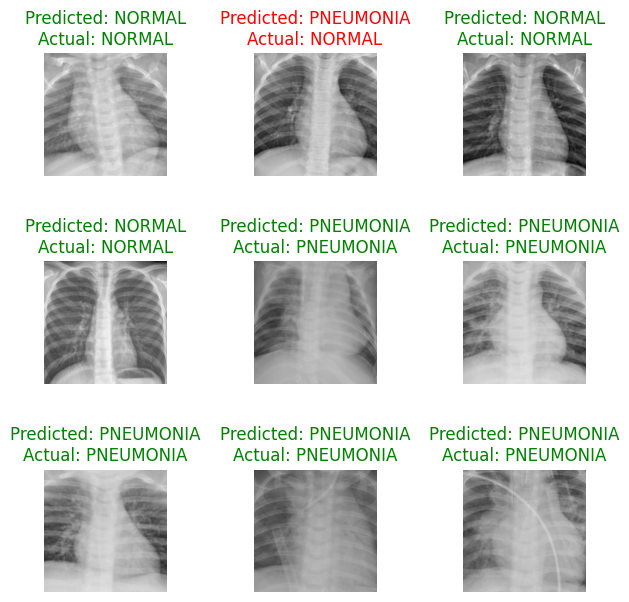

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(7, 7))
fig.subplots_adjust(hspace=0.7, wspace=0.7)
x = 0
for i in range(3):
    for j in range(3):
        inp = input_images[x].squeeze().cpu().numpy().transpose((1, 2, 0))
        true_label = true_labels[x]
        pred_label = pred_labels[x]

        # Normalize the image for display
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)

        # Display the image
        axes[i, j].imshow(inp)

        # Set the title with the predicted and actual labels
        title = f"Predicted: {class_names[pred_label]}\nActual: {class_names[true_label]}"
        color = 'green' if pred_label == true_label else 'red'
        axes[i, j].set_title(title, color=color)
        axes[i, j].axis('off')
        x += 1

plt.show()



In [ ]:
print(f"Total Correct: {running_correct} \nTotal Test Images: {running_total}")
print(f"Accuracy: {acc:.4f}")


Total Correct: 545.0 
Total Test Images: 624.0
Accuracy: 0.8734


In [ ]:
# prompt: write a code for percision, recall, f1 score for both normal and pneumonia

from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming you have true_labels and pred_labels from your test_model function

# Calculate precision, recall, and F1-score for both classes
precision_normal = precision_score(true_labels, pred_labels, pos_label=0, average='binary')
recall_normal = recall_score(true_labels, pred_labels, pos_label=0, average='binary')
f1_normal = f1_score(true_labels, pred_labels, pos_label=0, average='binary')

precision_pneumonia = precision_score(true_labels, pred_labels, pos_label=1, average='binary')
recall_pneumonia = recall_score(true_labels, pred_labels, pos_label=1, average='binary')
f1_pneumonia = f1_score(true_labels, pred_labels, pos_label=1, average='binary')

print("Normal:")
print("Precision:", precision_normal)
print("Recall:", recall_normal)
print("F1-score:", f1_normal)

print("\nPneumonia:")
print("Precision:", precision_pneumonia)
print("Recall:", recall_pneumonia)
print("F1-score:", f1_pneumonia)

Normal:
Precision: 0.9813664596273292
Recall: 0.6752136752136753
F1-score: 0.8

Pneumonia:
Precision: 0.8358531317494601
Recall: 0.9923076923076923
F1-score: 0.9073856975381008


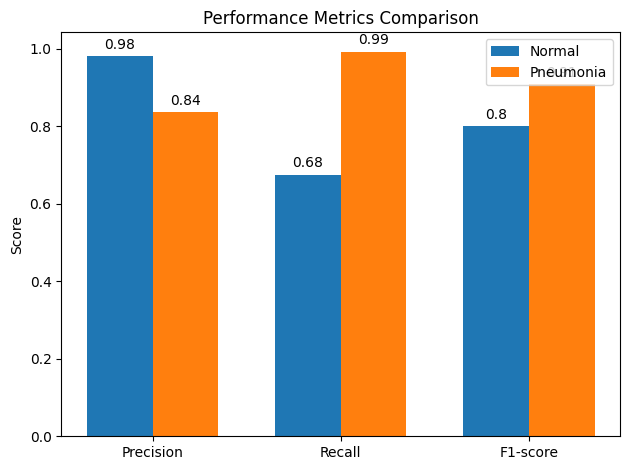

In [ ]:
# prompt: draw a comparision graph for performance metrics

import matplotlib.pyplot as plt

# Sample data (replace with your actual precision, recall, and F1-score values)
metrics = {
    'Normal': {'Precision': precision_normal, 'Recall': recall_normal, 'F1-score': f1_normal},
    'Pneumonia': {'Precision': precision_pneumonia, 'Recall': recall_pneumonia, 'F1-score': f1_pneumonia}
}

# Create the bar chart
labels = ['Precision', 'Recall', 'F1-score']
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, [metrics['Normal']['Precision'], metrics['Normal']['Recall'], metrics['Normal']['F1-score']], width, label='Normal')
rects2 = ax.bar(x + width/2, [metrics['Pneumonia']['Precision'], metrics['Pneumonia']['Recall'], metrics['Pneumonia']['F1-score']], width, label='Pneumonia')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Performance Metrics Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add labels above the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

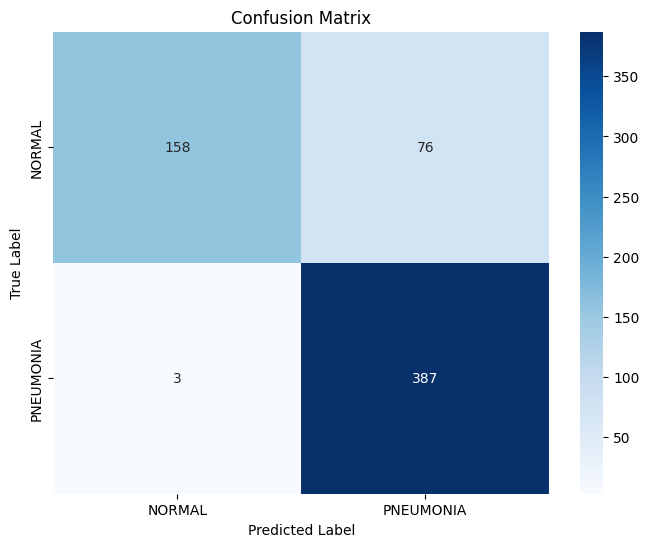

In [ ]:
# prompt: write confussion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have true_labels and pred_labels from your test_model function

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()